In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
# print("TF: ", tf.__version__)
from keras import layers, models, Model
import keras

from pathlib import Path
from keras.preprocessing.image import load_img, img_to_array, image_dataset_from_directory
from keras.applications import vgg16, vgg19

import utils
# import wandb
# from wandb.keras import WandbCallback

TF:  2.7.0


In [2]:
utils.seed_everything()

# Get base project directory
project_path = Path(os.getcwd()).parent.parent
datapath = (project_path /'data/processed/')

CLASSES = {0 : 'yes', 1 : 'no'}

In [3]:
# Dataset inspect
# Read images to variables
size = 224
# X_train, y_train = get_training_set(CLASSES, size)
X_train, y_train = utils.get_sets('train', CLASSES, size)
X_val, y_val = utils.get_sets('val', CLASSES, size)
X_test, y_test = utils.get_sets('test', CLASSES, size)

In [4]:
configs = dict(
    image_width = X_train[0].shape[0],
    image_height = X_train[0].shape[1],
    image_channels = X_train[0].shape[2],
    batch_size = 4,
    class_names = CLASSES,
    model_name = '', # set after model is defined
    pretrain_weights = 'imagenet',
    epochs = 5,
    init_learning_rate = 0.001,
    lr_decay_rate = 0.1,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['accuracy'],
    earlystopping_patience = 5,
    architecture = "",# To be defined f"{base_model._name.upper()} global_average_pooling2d",
    dataset = "Brain_MRI_Images_for_Brain_Tumor_Detection"
)

In [5]:
list_names = []
shape = (X_train[0].shape[0], X_train[0].shape[1], 3)
base_model = vgg19.VGG19(weights=configs['pretrain_weights'], include_top=False, input_shape=shape)
base_model.trainable = False
for layer in base_model.layers:
    if str(type(layer)).split('.')[2] != 'input_layer':
        print(str(type(layer)).split('.')[2])
    list_names.append(layer._name)
print(list_names)

convolutional
convolutional
pooling
convolutional
convolutional
pooling
convolutional
convolutional
convolutional
convolutional
pooling
convolutional
convolutional
convolutional
convolutional
pooling
convolutional
convolutional
convolutional
convolutional
pooling
['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_conv4', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_conv4', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


In [6]:
base_model.layers[0]

In [18]:
def get_model(input_shape: tuple=(32, 32, 3),
              output_activation: str='sigmoid'):
    shape = (X_train[0].shape[0], X_train[0].shape[1], 3)
    inputs = layers.Input(input_shape)

    base_model = vgg19.VGG19(weights=configs['pretrain_weights'], include_top=False, input_shape=shape)
    base_model.trainable = False

    configs['architecture'] = base_model._name

    # inputs = layers.Input(shape=list(shape))
    # inputs = base_model.layers[0].input
    # x = vgg19.preprocess_input(inputs)
    # for c, layer in enumerate(base_model.layers):
    #     if c >= 0:
    #         x = layer(x)
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    
    outputs = layers.Dense(1, activation=output_activation)(x)
    model  = models.Model(base_model.input, outputs, name=f'Baseline_{base_model._name.upper()}')
    return model

# tf.keras.backend.clear_session()
model = get_model()
model.summary()

Model: "Baseline_VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)    

In [19]:
# checkpoint_filepath = (Path(os.getcwd()) /'model_checkpoint/model_checkpoint')

# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [20]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=configs['earlystopping_patience'], verbose=0, mode='auto',
    restore_best_weights=True
)

In [28]:
def train(config: dict,
          callbacks: list,
          verbose: int=0):
    """
    Utility function to train the model.

    Arguments:
        config (dict): Dictionary of hyperparameters.
        callbacks (list): List of callbacks passed to `model.fit`.
        verbose (int): 0 for silent and 1 for progress bar.
    """

    # Initalize model
    # tf.keras.backend.clear_session()
    model = get_model(input_shape=(config['image_width'], config['image_height'], config['image_channels']))
    config['model_name'] = model.name # set


    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=config['init_learning_rate'])
    model.compile(optimizer=opt,
                  loss=config['loss_fn'],
                  metrics=config['metrics'])
# model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
    # Train the model
    _ = model.fit(vgg19.preprocess_input(X_train), y_train,
                  epochs=config['epochs'],
                  validation_data=(np.array(X_val),np.array(y_val)),
                  callbacks=callbacks,
                  batch_size=config['batch_size'],
                  verbose=verbose)

    return model

In [29]:
config = configs
callbacks = [earlystopper]

model = train(config, callbacks=callbacks, verbose=2)


Epoch 1/5
32/32 - 3s - loss: 1.2489 - accuracy: 0.5280 - val_loss: 1.5742 - val_accuracy: 0.5238 - 3s/epoch - 80ms/step
Epoch 2/5
32/32 - 1s - loss: 0.7659 - accuracy: 0.6800 - val_loss: 1.5392 - val_accuracy: 0.5952 - 1s/epoch - 42ms/step
Epoch 3/5
32/32 - 1s - loss: 0.6041 - accuracy: 0.7280 - val_loss: 1.3192 - val_accuracy: 0.5952 - 1s/epoch - 42ms/step
Epoch 4/5
32/32 - 1s - loss: 0.4880 - accuracy: 0.7840 - val_loss: 1.2054 - val_accuracy: 0.6190 - 1s/epoch - 42ms/step
Epoch 5/5
32/32 - 1s - loss: 0.4199 - accuracy: 0.8080 - val_loss: 1.2300 - val_accuracy: 0.6429 - 1s/epoch - 40ms/step


In [30]:
last_conv_layer_name = 'block5_conv4'

In [34]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        #[model.inputs], [model.get_layer('vgg19').get_layer(last_conv_layer_name).output, model.output]
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [35]:
# for l in model.get_layer('vgg19').layers:
#     print(l._name)

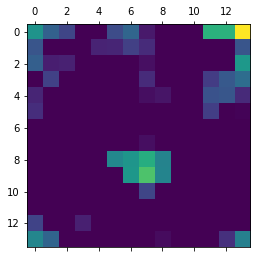

In [36]:
x = np.expand_dims(X_train[0], axis=0)
# x = keras.preprocessing.image.img_to_array(x)
# Print what the top predicted class is
preds = model.predict(x)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(x, model, "block5_conv4")

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
for l in model.layers:
    print(l._name)